## Sentiment Classification with SpaCy
> **March, 20 2023**
---

#### [Faculdade de Tecnologia (Fatec) Baixada Santista](https://fatecrl.edu.br/)
- Natural Language Processing

In [1]:
!python -m spacy download pt_core_news_sm > /dev/null # Silencioso

In [2]:
import spacy # Biblioteca principal

from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import Markdown as md
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np

pln = spacy.load('pt_core_news_sm')
stop_words = STOP_WORDS

#### Carregamento de Dados

In [3]:
df = pd.read_csv('/kaggle/input/TweetSentimentBR/Train.csv')

# Transformando os dados em categoria
df['sentiment'] = df['sentiment'].astype('category')
df['query_used'] = df['query_used'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          50000 non-null  int64   
 1   tweet_text  50000 non-null  object  
 2   tweet_date  50000 non-null  object  
 3   sentiment   50000 non-null  category
 4   query_used  50000 non-null  category
dtypes: category(2), int64(1), object(2)
memory usage: 1.2+ MB


In [4]:
display(pd.crosstab(df['sentiment'], df['query_used'], normalize='index'))

df['sentiment'].value_counts()

query_used   :(   :)
sentiment           
0           1.0  0.0
1           0.0  1.0

sentiment
0    25000
1    25000
Name: count, dtype: int64

#### Função | Pré-processamento de Textos

In [5]:
display(md(f'### StopWords: `{len(stop_words)}`'))
pontuacoes = string.punctuation
pontuacoes

### StopWords: `416`

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
# Pré-processamento de texto
def preproc(texto):
    texto = texto.lower()
    documento = pln(texto)

    lista = []
    for token in documento: lista.append(token.lemma_)

    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
    
    # Removendo o @user para não influênciar no modelo
    filtro = []
    for palavra in lista:
        if palavra.startswith('@'): continue
        else: filtro.append(palavra)
    
    lista = ' '.join([str(elemento) for elemento in filtro if not elemento.isdigit()])
    
    return lista

## Pré-processamento

In [7]:
df.sample(3)

id                                         tweet_text  \
45723  1046915935251128320  @pepeidc__ HAHAHAHA LMAOOO tipo Bucky Barnes v...   
20873  1049162947128246273        foo  : 6011d6df-c36e-4f9a-a1af-4987587b7724   
5603   1047556013522649088  @JliaRusch @igorvieiradss @joaopedsc @__MariaJ...   

                           tweet_date sentiment query_used  
45723  Tue Oct 02 00:13:04 +0000 2018         0         :(  
20873  Mon Oct 08 05:01:53 +0000 2018         1         :)  
5603   Wed Oct 03 18:36:30 +0000 2018         1         :)

In [8]:
# Aplicação do pre-processamento
processados = [preproc(text) for text in tqdm(df['tweet_text'], desc="Proc.")]
df['tweet_text'] = processados
df.sample(3)

Proc.: 100%|██████████| 50000/50000 [07:34<00:00, 110.01it/s]


id                                         tweet_text  \
4648   1049299573041184768  jogar algum game — jogar   https://t.co/6ejkft...   
35561  1047340398178447360                                   twitter facebook   
6141   1046928622689378305                                querer camera volta   

                           tweet_date sentiment query_used  
4648   Mon Oct 08 14:04:47 +0000 2018         0         :(  
35561  Wed Oct 03 04:19:44 +0000 2018         1         :)  
6141   Tue Oct 02 01:03:29 +0000 2018         0         :(

## Definição da Classe

In [10]:
X, _, y, _ = train_test_split(
    df['tweet_text'], df['sentiment'],
    train_size=.05,
    stratify=df['sentiment']
)
len(X)

2500

In [11]:
df_final = []

for tweet, sentimento in zip(df['tweet_text'], df['sentiment']):
#for tweet, sentimento in zip(X, y):
    if sentimento == 1:
        dic = ({'POSITIVO': True, 'NEGATIVO': False})
        
    elif sentimento == 0:
        dic = ({'POSITIVO': False, 'NEGATIVO': True})
        
    else:
        dic = ({'POSITIVO': False, 'NEGATIVO': False})
    
    df_final.append([tweet, dic.copy()])

In [12]:
df_final[5]

['querer mt aproveitar pra rodar Brasil morro medo ficar mt ônibus',
 {'POSITIVO': False, 'NEGATIVO': True}]

## Criação do Classificador

In [13]:
from spacy.training import Example

modelo = spacy.blank('pt')
textcat = modelo.add_pipe("textcat")
textcat.add_label("POSITIVO")
textcat.add_label("NEGATIVO")
historico = []

In [14]:
modelo.begin_training()
for epoca in tqdm(range(25), desc="Treinando o Modelo"):
    random.shuffle(df_final)
    losses = {}
    for batch in spacy.util.minibatch(df_final, 30):
        textos = [modelo(texto) for texto, entities in batch]
        annotations = [{'cats': entities} for texto, entities in batch]
        examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(
            textos, annotations
        )]
        modelo.update(examples, losses=losses)
    display(md(f'#### Perda: `{losses["textcat"]}`'))
    historico.append(losses)

[2024-03-25 18:21:45,263] [INFO] Created vocabulary
[2024-03-25 18:21:45,265] [INFO] Finished initializing nlp object
Treinando o Modelo:   0%|          | 0/25 [00:00<?, ?it/s]

#### Perda: `285.97219578921795`

Treinando o Modelo:   4%|▍         | 1/25 [02:43<1:05:26, 163.61s/it]

#### Perda: `230.33367532677948`

Treinando o Modelo:   8%|▊         | 2/25 [05:20<1:01:18, 159.91s/it]

#### Perda: `184.07724867016077`

Treinando o Modelo:  12%|█▏        | 3/25 [07:58<58:13, 158.79s/it]  

#### Perda: `143.06137653905898`

Treinando o Modelo:  16%|█▌        | 4/25 [10:36<55:27, 158.43s/it]

#### Perda: `113.41953892225865`

Treinando o Modelo:  20%|██        | 5/25 [13:14<52:44, 158.23s/it]

#### Perda: `96.837604508386`

Treinando o Modelo:  24%|██▍       | 6/25 [15:52<50:03, 158.10s/it]

#### Perda: `84.05491932437872`

Treinando o Modelo:  28%|██▊       | 7/25 [18:30<47:30, 158.34s/it]

#### Perda: `74.61184167407191`

Treinando o Modelo:  32%|███▏      | 8/25 [21:09<44:55, 158.53s/it]

#### Perda: `69.88105845711107`

Treinando o Modelo:  36%|███▌      | 9/25 [23:48<42:16, 158.55s/it]

#### Perda: `65.01338230235706`

Treinando o Modelo:  40%|████      | 10/25 [26:26<39:34, 158.27s/it]

#### Perda: `61.03931204467335`

Treinando o Modelo:  44%|████▍     | 11/25 [29:03<36:54, 158.17s/it]

#### Perda: `57.66531999259553`

Treinando o Modelo:  48%|████▊     | 12/25 [31:41<34:13, 157.99s/it]

#### Perda: `55.550110810243496`

Treinando o Modelo:  52%|█████▏    | 13/25 [34:18<31:33, 157.79s/it]

#### Perda: `52.58756131958967`

Treinando o Modelo:  56%|█████▌    | 14/25 [36:56<28:54, 157.64s/it]

#### Perda: `51.28484438186115`

Treinando o Modelo:  60%|██████    | 15/25 [39:33<26:15, 157.59s/it]

#### Perda: `50.53737298712986`

Treinando o Modelo:  64%|██████▍   | 16/25 [42:10<23:36, 157.39s/it]

#### Perda: `47.298940913994784`

Treinando o Modelo:  68%|██████▊   | 17/25 [44:47<20:58, 157.34s/it]

#### Perda: `46.359281323709524`

Treinando o Modelo:  72%|███████▏  | 18/25 [47:24<18:20, 157.27s/it]

#### Perda: `45.10213475397461`

Treinando o Modelo:  76%|███████▌  | 19/25 [50:02<15:43, 157.28s/it]

#### Perda: `44.452012515154365`

Treinando o Modelo:  80%|████████  | 20/25 [52:39<13:06, 157.22s/it]

#### Perda: `44.19212562365749`

Treinando o Modelo:  84%|████████▍ | 21/25 [55:17<10:30, 157.52s/it]

#### Perda: `42.84135688029434`

Treinando o Modelo:  88%|████████▊ | 22/25 [57:55<07:53, 157.79s/it]

#### Perda: `42.616057789069885`

Treinando o Modelo:  92%|█████████▏| 23/25 [1:00:34<05:16, 158.05s/it]

#### Perda: `40.40634561429084`

Treinando o Modelo:  96%|█████████▌| 24/25 [1:03:15<02:38, 158.89s/it]

#### Perda: `39.619447535969385`

Treinando o Modelo: 100%|██████████| 25/25 [1:05:56<00:00, 158.25s/it]


In [15]:
historico_loss = []

for i in historico: historico_loss.append(i.get('textcat'))

historico_loss.append(0) # Só para ter mostrar o eixo 0
historico_loss = np.array(historico_loss)
historico_loss

array([285.97219579, 230.33367533, 184.07724867, 143.06137654,
       113.41953892,  96.83760451,  84.05491932,  74.61184167,
        69.88105846,  65.0133823 ,  61.03931204,  57.66531999,
        55.55011081,  52.58756132,  51.28484438,  50.53737299,
        47.29894091,  46.35928132,  45.10213475,  44.45201252,
        44.19212562,  42.84135688,  42.61605779,  40.40634561,
        39.61944754,   0.        ])

Text(0, 0.5, 'Erro')

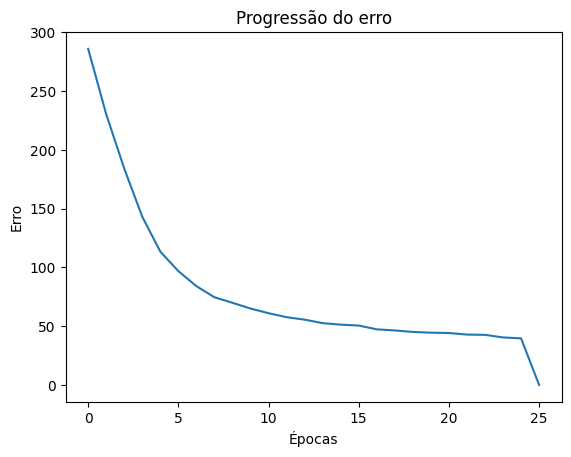

In [16]:
import matplotlib.pyplot as plt

plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [17]:
# Exportando o modelo
modelo.to_disk("modelo")

## `6` Teste com Frases

In [18]:
modelo_carregado = spacy.load("/kaggle/working/modelo")
modelo_carregado

In [41]:
texto_positivo = 'Eu odeio a felicidade dele sobre o livro: Amor e Ódio'

texto_positivo = preproc(texto_positivo)
previsao = modelo_carregado(texto_positivo)

display(md(f"### Bom: `{round(previsao.cats['POSITIVO'], 4)}` | Ruim `{round(previsao.cats['NEGATIVO'], 4)}`"))

### Bom: `0.551` | Ruim `0.449`

## Avaliação do Modelo

In [20]:
test = pd.read_csv('/kaggle/input/TweetSentimentBR/Test.csv')

In [21]:
previsoes = []
for texto in df['tweet_text']:
    previsao = modelo_carregado(texto)
    previsoes.append(previsao.cats)

In [22]:
pred = []
for previsao in previsoes:
    if previsao['POSITIVO'] > previsao['NEGATIVO']: pred.append(1)
    else: pred.append(0)

pred = np.array(pred)
pred

array([0, 1, 1, ..., 0, 1, 1])

In [23]:
y = df['sentiment'].values

### Acurácia: 0.97136

<Axes: >

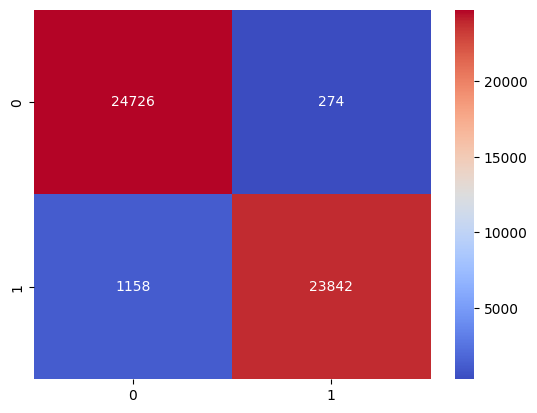

In [24]:
display(md(f'### Acurácia: {accuracy_score(y, pred)}'))

cm = confusion_matrix(y, pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')

In [25]:
previsoes = []
for texto in test['tweet_text']:
    previsao = modelo_carregado(texto)
    previsoes.append(previsao.cats)
    
pred = []
for previsao in previsoes:
    if previsao['POSITIVO'] > previsao['NEGATIVO']: pred.append(1)
    else: pred.append(0)

pred = np.array(pred)
pred

array([1, 1, 0, ..., 0, 0, 1])

In [26]:
submission = pd.DataFrame({'id': test['id'], 'sentiments': pred})
submission.to_csv('submission_final.csv', sep=',', index=False)